<a href="https://colab.research.google.com/github/JulienGremillot/OpenClassrooms_Ingenieur_Machine_Learning/blob/main/P8%20-%20Participez%20%C3%A0%20une%20comp%C3%A9tition%20Kaggle/petfinder_pawpularity_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tests sur le jeu de données petfinder-pawpularity-score

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from PIL import Image
from skimage import img_as_float
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import EfficientNetB0

In [2]:
drive.mount("/content/gdrive", force_remount=False)
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
print("Répertoire de travail courant : %s" % os.getcwd())

Mounted at /content/gdrive
Répertoire de travail courant : /content/gdrive/MyDrive/Colab Notebooks


In [3]:
data = pd.read_csv("petfinder-pawpularity-score/train.csv", sep=',') # séparateur = virgule
data

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


In [4]:
width, height = 224, 224
dataset_dir = 'petfinder-pawpularity-score/train'
TEST_LIMIT = 100  # pour l'instant on prend juste les 100 premières images
images = []
pawpularities = []
for image_file in tqdm(os.listdir(dataset_dir)):
    img_path = os.path.join(dataset_dir, image_file)
    img = Image.open(img_path)
    img = img.resize((width, height))
    images.append(img_as_float(img))
    id = image_file.split('.')[0]
    pawpularities.append(data[data['Id'] == id]['Pawpularity'].to_numpy()[0])
    TEST_LIMIT = TEST_LIMIT - 1
    if TEST_LIMIT == 0:
        break
images = np.array(images)
images = images / 255.0
pawpularities = np.array(pawpularities)
pawpularities = (pawpularities - 1) / 100.0  # -1 car [1, 100] on veut [0, 1)

print(images.shape, pawpularities.shape)

  1%|          | 99/9912 [00:40<1:06:18,  2.47it/s]

(100, 224, 224, 3) (100,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    images, pawpularities, test_size=0.2, random_state=42
)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(80, 224, 224, 3) (80,)


In [12]:
def show_perfs(history, epochs):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    if 'accuracy' in history.history:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [7]:
efficientnet = EfficientNetB0(include_top=False, weights='imagenet',
                              input_shape=(height, width, 3))
for layer in efficientnet.layers:
        layer.trainable = False
flat1 = Flatten()(efficientnet.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(1, activation='linear')(class1)
efficientnet = Model(inputs=efficientnet.inputs, outputs=output)
efficientnet.compile(optimizer=Adam(lr=1e-3, decay=1e-3 / 200),  #'sgd'
              loss="mean_absolute_percentage_error")

16719872/16705208 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
epochs = 200
batch_size = 8
history_efficientnet = efficientnet.fit(
  X_train, y_train,
  validation_data=(X_test, y_test),
  epochs=epochs, batch_size=batch_size
)

Epoch 1/200
10/10 [==============================] - 22s 1s/step - loss: 28679.4688 - val_loss: 1263.1007
Epoch 2/200
10/10 [==============================] - 11s 1s/step - loss: 2301.1841 - val_loss: 4318.8120
Epoch 3/200
10/10 [==============================] - 14s 1s/step - loss: 4216.7295 - val_loss: 1452.3374
Epoch 4/200
10/10 [==============================] - 11s 1s/step - loss: 2404.7600 - val_loss: 156.4773
Epoch 5/200
10/10 [==============================] - 11s 1s/step - loss: 1360.7650 - val_loss: 680.0043
Epoch 6/200
10/10 [==============================] - 11s 1s/step - loss: 1654.4255 - val_loss: 469.6924
Epoch 7/200
10/10 [==============================] - 10s 1s/step - loss: 702.6016 - val_loss: 373.6891
Epoch 8/200
10/10 [==============================] - 11s 1s/step - loss: 814.5142 - val_loss: 467.2690
Epoch 9/200
10/10 [==============================] - 15s 2s/step - loss: 3464.6731 - val_loss: 2384.5811
Epoch 10/200
10/10 [==============================] - 11s 1s/

KeyError: ignored

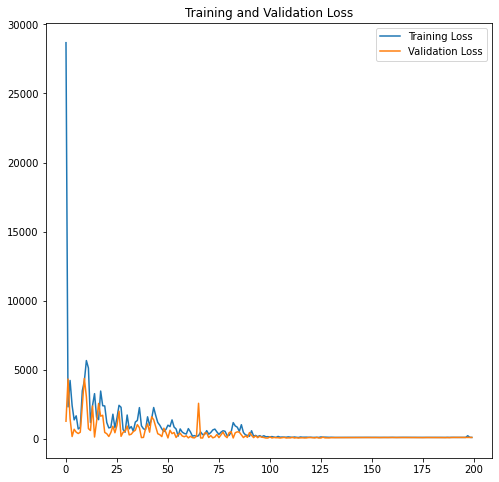

In [13]:
show_perfs(history_efficientnet, epochs)

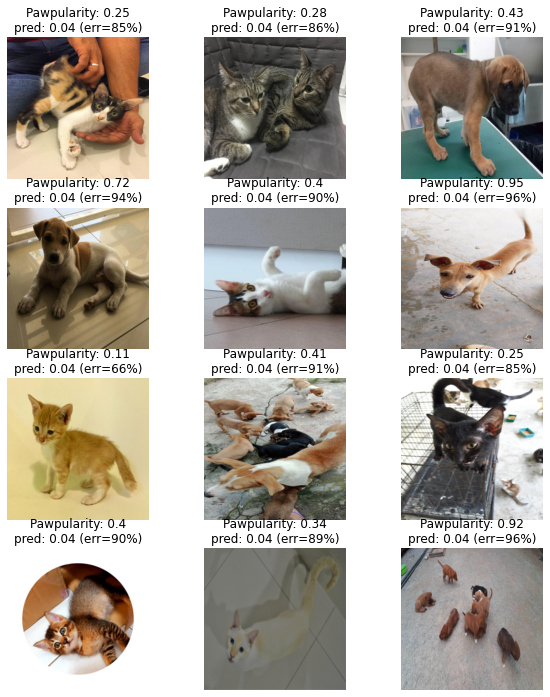

In [36]:
def predict(index):
  """
  model predicts one of the 1000 ImageNet classes
  """
  image = X_test[index] * 255
  img = image.reshape(1, 224, 224, 3)
  preds = efficientnet.predict(img)
  pawpularity = y_test[index]
  prediction = preds.flatten()[0]
  diff = prediction - pawpularity
  percentDiff = (diff / pawpularity) * 100
  absPercentDiff = np.abs(percentDiff)

  plt.subplot(4, 3, index + 1)
  plt.title("Pawpularity: " + str(y_test[index]) +\
            "\npred: " + str(round(prediction, 2)) +\
            " (err=" + str(int(absPercentDiff)) + "%)")
  plt.imshow(image)
  plt.axis("off")

plt.figure(figsize=(10, 12))
for i in range(12):
  predict(i)